In [1]:
# Importing libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP_action import GP_action
import time
import imageio
import pickle

In [2]:
Noise=False# Specify if noisy or not
Noise_level= 0.05 # if noisy, what is the noise sd
'''If the scaled X and Y is being used rememeber to scale the noise as well'''

'If the scaled X and Y is being used rememeber to scale the noise as well'

In [3]:
# The target function is assigned, chose 1 from the below

objective=functions.Ackley()
objective=functions.Rosenbrock()
objective=functions.Synthetic()
objective=functions.sin()
objective=functions.sin_2(Noise,Noise_level)
objective=functions.sincos(Noise,Noise_level)
objective=functions.Branin()
objective=functions.Shubert(Noise,Noise_level)
objective=functions.Kean(Noise,Noise_level)
objective=functions.Hartmann_3()
objective=functions.Hartmann_6()
objective=functions.Kean(Noise,Noise_level)
objective=functions.Ackley_6()
objective=functions.Shubert()



print(objective.bounds)
# Extracting the bounded range of the inputs
func_bounds=bounds=np.array(
            [item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])],dtype=np.float)
print(func_bounds)
print(objective.func(np.array([0,0,0,0,0,0])))


{'x': (-3, 1), 'y': (-3, 1)}
[[-3.  1.]
 [-3.  1.]]
1.2056245647537474


In [4]:
# max budget for finding good point
Budget=200

# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES','GD']
acquation_function='gp_ucb'
function_bounds=func_bounds
func_name='Shubert'
Max= 2.1 # function max 3.86278, 3.32237

In [5]:

acq=['GD','gp_ucb','EI','TS']
Mean_dict = {} 
std_dict={}
k=0
mean=np.zeros(200)
std=np.zeros(200)
seed=np.random.randint(10000, size=5)
while(k<4):
    temp_out=np.zeros(200)
    seed_count=0
    for m in range(0,5):
        samples=[]
        acquation_function=acq[k]
        seeds=seed[seed_count]
        Bo_test=GP_action(objective.func,function_bounds,Noise,Noise_level,acquation_function)
        Bo_test.initiate(seeds,n_random_draws=5)
        seed_count=seed_count+1
        flag = True
        i = 0
        samples.append(Max-np.max(Bo_test.Y))
        while flag:
            if i >= (Budget-1) :
                break
            Bo_test.sample_new_value()
            Regret= Max-np.max(Bo_test.Y)
            samples.append(Regret)
            i += 1
    
        out=np.array(samples)
        temp_out=np.vstack((temp_out, out))
        
    temp_out = np.delete(temp_out,(0), axis=0)
    mean_temp=np.mean(temp_out,axis=0)
    std_temp=0.5*np.sqrt(np.var(temp_out,axis=0)) # Calculating the one sided interval for 90% confidence

    mean=np.vstack((mean,mean_temp))
    std=np.vstack((std,std_temp))
    Mean_dict[acquation_function]=mean_temp
    std_dict[acquation_function]=std_temp
    k=k+1
    


1 1
1
estimated lengthscale and variance [1.  1.5]
1 1
2
1 1
3
1 1
4
estimated lengthscale and variance [1.  1.5]
1 1
5
1 1
6
1 1
7
estimated lengthscale and variance [1.  1.5]
1 1
8
1 1
9
1 1
10
estimated lengthscale and variance [1.  1.5]
1 1
11
1 1
12
1 1
13
estimated lengthscale and variance [1.  1.5]
1 1
14
1 1
15
1 1
16
estimated lengthscale and variance [1.  1.5]
1 1
17
1 1
18
1 1
19
estimated lengthscale and variance [1.  1.5]
1 1
20
1 1
21
1 1
22
estimated lengthscale and variance [1.  1.5]
1 1
23
1 1
24
1 1
25
estimated lengthscale and variance [1.  1.5]
1 1
26
1 1
27
1 1
28
estimated lengthscale and variance [1.  1.5]
1 1
29
1 1
30
1 1
31
estimated lengthscale and variance [1.         0.69183704]
1 1
32
1 1
33
1 1
34
estimated lengthscale and variance [0.97597416 1.19756812]
1 1
35
1 1
36
1 1
37
estimated lengthscale and variance [1.  1.5]
1 1
38
1 1
39
1 1
40
estimated lengthscale and variance [1.  1.5]
1 1
41
1 1
42
1 1
43
estimated lengthscale and variance [1.  1.5]
1 1
4

161
1 1
162
1 1
163
estimated lengthscale and variance [1.  1.5]
1 1
164
1 1
165
1 1
166
estimated lengthscale and variance [1.  1.5]
1 1
167
1 1
168
1 1
169
estimated lengthscale and variance [1.  1.5]
1 1
170
1 1
171
1 1
172
estimated lengthscale and variance [1.         1.41694661]
1 1
173
1 1
174
1 1
175
estimated lengthscale and variance [1.  1.5]
1 1
176
1 1
177
1 1
178
estimated lengthscale and variance [1.  1.5]
1 1
179
1 1
180
1 1
181
estimated lengthscale and variance [1.  1.5]
1 1
182
1 1
183
1 1
184
estimated lengthscale and variance [1.  1.5]
1 1
185
1 1
186
1 1
187
estimated lengthscale and variance [1.  1.5]
1 1
188
1 1
189
1 1
190
estimated lengthscale and variance [1.  1.5]
1 1
191
1 1
192
1 1
193
estimated lengthscale and variance [1.  1.5]
1 1
194
1 1
195
1 1
196
estimated lengthscale and variance [1.  1.5]
1 1
197
1 1
198
1 1
199
1 1
1
estimated lengthscale and variance [1.         1.21503972]
1 1
2
1 1
3
1 1
4
estimated lengthscale and variance [1.  1.5]
1 1
5
1 1


113
1 1
114
1 1
115
estimated lengthscale and variance [1.         1.49999998]
1 1
116
1 1
117
1 1
118
estimated lengthscale and variance [1.  1.5]
1 1
119
1 1
120
1 1
121
estimated lengthscale and variance [1.  1.5]
1 1
122
1 1
123
1 1
124
estimated lengthscale and variance [0.9987124  1.27553488]
1 1
125
1 1
126
1 1
127
estimated lengthscale and variance [1.  1.5]
1 1
128
1 1
129
1 1
130
estimated lengthscale and variance [1.  1.5]
1 1
131
1 1
132
1 1
133
estimated lengthscale and variance [1.         1.49999999]
1 1
134
1 1
135
1 1
136
estimated lengthscale and variance [1.  1.5]
1 1
137
1 1
138
1 1
139
estimated lengthscale and variance [1.         1.49999999]
1 1
140
1 1
141
1 1
142
estimated lengthscale and variance [1.         0.98487317]
1 1
143
1 1
144
1 1
145
estimated lengthscale and variance [1.         1.49999998]
1 1
146
1 1
147
1 1
148
estimated lengthscale and variance [1.  1.5]
1 1
149
1 1
150
1 1
151
estimated lengthscale and variance [1.  1.5]
1 1
152
1 1
153
1 1
154

66
1 1
67
estimated lengthscale and variance [1.  1.5]
1 1
68
1 1
69
1 1
70
estimated lengthscale and variance [1.  1.5]
1 1
71
1 1
72
1 1
73
estimated lengthscale and variance [1.         1.03564532]
1 1
74
1 1
75
1 1
76
estimated lengthscale and variance [1.  1.5]
1 1
77
1 1
78
1 1
79
estimated lengthscale and variance [1.  1.5]
1 1
80
1 1
81
1 1
82
estimated lengthscale and variance [1.  1.5]
1 1
83
1 1
84
1 1
85
estimated lengthscale and variance [1.         1.49197658]
1 1
86
1 1
87
1 1
88
estimated lengthscale and variance [1.  1.5]
1 1
89
1 1
90
1 1
91
estimated lengthscale and variance [1.  1.5]
1 1
92
1 1
93
1 1
94
estimated lengthscale and variance [0.98304029 1.09741489]
1 1
95
1 1
96
1 1
97
estimated lengthscale and variance [1.         1.49999994]
1 1
98
1 1
99
1 1
100
estimated lengthscale and variance [1.  1.5]
1 1
101
1 1
102
1 1
103
estimated lengthscale and variance [1.  1.5]
1 1
104
1 1
105
1 1
106
estimated lengthscale and variance [1.  1.5]
1 1
107
1 1
108
1 1
109


22
estimated lengthscale and variance [1.  1.5]
1 1
23
1 1
24
1 1
25
estimated lengthscale and variance [1.  1.5]
1 1
26
1 1
27
1 1
28
estimated lengthscale and variance [1.  1.5]
1 1
29
1 1
30
1 1
31
estimated lengthscale and variance [1.  1.5]
1 1
32
1 1
33
1 1
34
estimated lengthscale and variance [1.  1.5]
1 1
35
1 1
36
1 1
37
estimated lengthscale and variance [1.  1.5]
1 1
38
1 1
39
1 1
40
estimated lengthscale and variance [1.  1.5]
1 1
41
1 1
42
1 1
43
estimated lengthscale and variance [1.  1.5]
1 1
44
1 1
45
1 1
46
estimated lengthscale and variance [1.  1.5]
1 1
47
1 1
48
1 1
49
estimated lengthscale and variance [1.  1.5]
1 1
50
1 1
51
1 1
52
estimated lengthscale and variance [1.  1.5]
1 1
53
1 1
54
1 1
55
estimated lengthscale and variance [1.  1.5]
1 1
56
1 1
57
1 1
58
estimated lengthscale and variance [1.  1.5]
1 1
59
1 1
60
1 1
61
estimated lengthscale and variance [1.  1.5]
1 1
62
1 1
63
1 1
64
estimated lengthscale and variance [1.  1.5]
1 1
65
1 1
66
1 1
67
estimat

170
1 1
171
1 1
172
estimated lengthscale and variance [1.  1.5]
1 1
173
1 1
174
1 1
175
estimated lengthscale and variance [1.  1.5]
1 1
176
1 1
177
1 1
178
estimated lengthscale and variance [1.  1.5]
1 1
179
1 1
180
1 1
181
estimated lengthscale and variance [1.  1.5]
1 1
182
1 1
183
1 1
184
estimated lengthscale and variance [1.  1.5]
1 1
185
1 1
186
1 1
187
estimated lengthscale and variance [1.  1.5]
1 1
188
1 1
189
1 1
190
estimated lengthscale and variance [1.         0.72130306]
1 1
191
1 1
192
1 1
193
estimated lengthscale and variance [1.  1.5]
1 1
194
1 1
195
1 1
196
estimated lengthscale and variance [1.  1.5]
1 1
197
1 1
198
1 1
199
1 1
1
estimated lengthscale and variance [1.  1.5]
1 1
2
1 1
3
1 1
4
estimated lengthscale and variance [1.  1.5]
1 1
5
1 1
6
1 1
7
estimated lengthscale and variance [1.  1.5]
1 1
8
1 1
9
1 1
10
estimated lengthscale and variance [1.  1.5]
1 1
11
1 1
12
1 1
13
estimated lengthscale and variance [1.  1.5]
1 1
14
1 1
15
1 1
16
estimated lengths

1 1
132
1 1
133
estimated lengthscale and variance [1.  1.5]
1 1
134
1 1
135
1 1
136
estimated lengthscale and variance [1.  1.5]
1 1
137
1 1
138
1 1
139
estimated lengthscale and variance [1.  1.5]
1 1
140
1 1
141
1 1
142
estimated lengthscale and variance [0.96622683 0.5997722 ]
1 1
143
1 1
144
1 1
145
estimated lengthscale and variance [1.         1.32329471]
1 1
146
1 1
147
1 1
148
estimated lengthscale and variance [1.  1.5]
1 1
149
1 1
150
1 1
151
estimated lengthscale and variance [1.  1.5]
1 1
152
1 1
153
1 1
154
estimated lengthscale and variance [1.         1.21803026]
1 1
155
1 1
156
1 1
157
estimated lengthscale and variance [1.         1.47938045]
1 1
158
1 1
159
1 1
160
estimated lengthscale and variance [0.8087578 0.69503  ]
1 1
161
1 1
162
1 1
163
estimated lengthscale and variance [1.        0.8278708]
1 1
164
1 1
165
1 1
166
estimated lengthscale and variance [1.         1.34781697]
1 1
167
1 1
168
1 1
169
estimated lengthscale and variance [1.         1.45697113]
1 1

88
estimated lengthscale and variance [1.        1.3741635]
1 1
89
1 1
90
1 1
91
estimated lengthscale and variance [1.  1.5]
1 1
92
1 1
93
1 1
94
estimated lengthscale and variance [1.  1.5]
1 1
95
1 1
96
1 1
97
estimated lengthscale and variance [1.  1.5]
1 1
98
1 1
99
1 1
100
estimated lengthscale and variance [1.  1.5]
1 1
101
1 1
102
1 1
103
estimated lengthscale and variance [1.        1.1858165]
1 1
104
1 1
105
1 1
106
estimated lengthscale and variance [1.  1.5]
1 1
107
1 1
108
1 1
109
estimated lengthscale and variance [1.         1.49999999]
1 1
110
1 1
111
1 1
112
estimated lengthscale and variance [1.  1.5]
1 1
113
1 1
114
1 1
115
estimated lengthscale and variance [1.         0.63223374]
1 1
116
1 1
117
1 1
118
estimated lengthscale and variance [1.  1.5]
1 1
119
1 1
120
1 1
121
estimated lengthscale and variance [1.  1.5]
1 1
122
1 1
123
1 1
124
estimated lengthscale and variance [1.         1.37658566]
1 1
125
1 1
126
1 1
127
estimated lengthscale and variance [1.       

36
1 1
37
estimated lengthscale and variance [1.  1.5]
1 1
38
1 1
39
1 1
40
estimated lengthscale and variance [1.  1.5]
1 1
41
1 1
42
1 1
43
estimated lengthscale and variance [1.  1.5]
1 1
44
1 1
45
1 1
46
estimated lengthscale and variance [1.  1.5]
1 1
47
1 1
48
1 1
49
estimated lengthscale and variance [1.  1.5]
1 1
50
1 1
51
1 1
52
estimated lengthscale and variance [1.  1.5]
1 1
53
1 1
54
1 1
55
estimated lengthscale and variance [1.  1.5]
1 1
56
1 1
57
1 1
58
estimated lengthscale and variance [1.  1.5]
1 1
59
1 1
60
1 1
61
estimated lengthscale and variance [1.  1.5]
1 1
62
1 1
63
1 1
64
estimated lengthscale and variance [1.  1.5]
1 1
65
1 1
66
1 1
67
estimated lengthscale and variance [1.  1.5]
1 1
68
1 1
69
1 1
70
estimated lengthscale and variance [1.  1.5]
1 1
71
1 1
72
1 1
73
estimated lengthscale and variance [1.  1.5]
1 1
74
1 1
75
1 1
76
estimated lengthscale and variance [1.  1.5]
1 1
77
1 1
78
1 1
79
estimated lengthscale and variance [1.  1.5]
1 1
80
1 1
81
1 1
82


180
1 1
181
estimated lengthscale and variance [1.  1.5]
1 1
182
1 1
183
1 1
184
estimated lengthscale and variance [1.  1.5]
1 1
185
1 1
186
1 1
187
estimated lengthscale and variance [0.99388065 1.35195914]
1 1
188
1 1
189
1 1
190
estimated lengthscale and variance [1.         1.22299752]
1 1
191
1 1
192
1 1
193
estimated lengthscale and variance [0.98002395 1.3432638 ]
1 1
194
1 1
195
1 1
196
estimated lengthscale and variance [1.  1.5]
1 1
197
1 1
198
1 1
199
1 1
1
estimated lengthscale and variance [1.  1.5]
1 1
2
1 1
3
1 1
4
estimated lengthscale and variance [1.  1.5]
1 1
5
1 1
6
1 1
7
estimated lengthscale and variance [1.  1.5]
1 1
8
1 1
9
1 1
10
estimated lengthscale and variance [1.  1.5]
1 1
11
1 1
12
1 1
13
estimated lengthscale and variance [1.  1.5]
1 1
14
1 1
15
1 1
16
estimated lengthscale and variance [1.  1.5]
1 1
17
1 1
18
1 1
19
estimated lengthscale and variance [1.  1.5]
1 1
20
1 1
21
1 1
22
estimated lengthscale and variance [1.  1.5]
1 1
23
1 1
24
1 1
25
estima

135
1 1
136
estimated lengthscale and variance [1.  1.5]
1 1
137
1 1
138
1 1
139
estimated lengthscale and variance [1.  1.5]
1 1
140
1 1
141
1 1
142
estimated lengthscale and variance [1.  1.5]
1 1
143
1 1
144
1 1
145
estimated lengthscale and variance [1.  1.5]
1 1
146
1 1
147
1 1
148
estimated lengthscale and variance [1.  1.5]
1 1
149
1 1
150
1 1
151
estimated lengthscale and variance [1.  1.5]
1 1
152
1 1
153
1 1
154
estimated lengthscale and variance [1.  1.5]
1 1
155
1 1
156
1 1
157
estimated lengthscale and variance [1.  1.5]
1 1
158
1 1
159
1 1
160
estimated lengthscale and variance [0.98549393 1.0937028 ]
1 1
161
1 1
162
1 1
163
estimated lengthscale and variance [1.  1.5]
1 1
164
1 1
165
1 1
166
estimated lengthscale and variance [1.  1.5]
1 1
167
1 1
168
1 1
169
estimated lengthscale and variance [0.97218284 1.24329514]
1 1
170
1 1
171
1 1
172
estimated lengthscale and variance [1.         1.49999996]
1 1
173
1 1
174
1 1
175
estimated lengthscale and variance [1.         1.

82
estimated lengthscale and variance [1.  1.5]
1 1
83
1 1
84
1 1
85
estimated lengthscale and variance [1.  1.5]
1 1
86
1 1
87
1 1
88
estimated lengthscale and variance [1.  1.5]
1 1
89
1 1
90
1 1
91
estimated lengthscale and variance [1.  1.5]
1 1
92
1 1
93
1 1
94
estimated lengthscale and variance [1.  1.5]
1 1
95
1 1
96
1 1
97
estimated lengthscale and variance [1.  1.5]
1 1
98
1 1
99
1 1
100
estimated lengthscale and variance [1.  1.5]
1 1
101
1 1
102
1 1
103
estimated lengthscale and variance [1.  1.5]
1 1
104
1 1
105
1 1
106
estimated lengthscale and variance [1.         1.21269191]
1 1
107
1 1
108
1 1
109
estimated lengthscale and variance [1.  1.5]
1 1
110
1 1
111
1 1
112
estimated lengthscale and variance [1.  1.5]
1 1
113
1 1
114
1 1
115
estimated lengthscale and variance [1.  1.5]
1 1
116
1 1
117
1 1
118
estimated lengthscale and variance [1.  1.5]
1 1
119
1 1
120
1 1
121
estimated lengthscale and variance [1.  1.5]
1 1
122
1 1
123
1 1
124
estimated lengthscale and variance

In [6]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [7]:
#save_obj(Mean_dict,func_name+'_Mean_'+'noisy_'+'Regret')
#save_obj(std_dict,func_name+'_Error_'+'noisy_'+'Regret')
save_obj(Mean_dict,func_name+'_Mean_'+'Regret')
save_obj(std_dict,func_name+'_Error_'+'Regret')



In [8]:
plt.style.use('default')
import seaborn as sns
colors = sns.color_palette("dark")
greens = sns.color_palette("BuGn", 10)
blues = sns.color_palette("PuBu", 10)
reds = sns.color_palette("YlOrRd", 10)
purples = sns.color_palette("PuOr", 10)

def save_plot_T(mean,std):
    GD=np.arange(0,200,1)
    GP_UCB=np.arange(0,200,1)
    EI=np.arange(0,200,1)
    i=200
    size=20 # error every size
    
    # naming the x axis 
    fig,(ax1)=plt.subplots(figsize=(4.5, 3))
    plt.xlabel('Queries', fontsize=10) 
    # naming the y axis 
    plt.ylabel('Simple Regret',fontsize=10) 
    # giving a title to my graph 
    plt.title('')
    # show a legend on the plot 
    plt.legend() 
    ax1.plot(GD[:i], mean['GD'][:i],'-',color=reds[-1]) 
    ax1.plot(GP_UCB[:i], mean['gp_ucb'][:i],'--',color=blues[-1]) 
    ax1.plot(EI[:i], mean['EI'][:i],'-.',color=purples[-1])
    ax1.plot(EI[:i], mean['TS'][:i],'-.',color=greens[-1])
    
    ax1.errorbar(GD[:i],mean['GD'][:i],yerr=std['GD'][:i],label="GD",linestyle='-',color=reds[-1],fmt='s',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(GP_UCB[:i],mean['gp_ucb'][:i],yerr=std['gp_ucb'][:i],label="gp_ucb",linestyle='--',color= blues[-1],fmt='^',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(EI[:i],mean['EI'][:i],yerr=std['EI'][:i],label="EI",linestyle='-.',color=purples[-1],fmt='>',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(EI[:i],mean['TS'][:i],yerr=std['TS'][:i],label="TS",linestyle=':',color=greens[-1],fmt='x',capsize=3,errorevery=size,markevery=size,lw=1.5)

    ax1.legend(loc='upper right',fontsize=10)
    # function to show the plot
#    plt.fill_between(x, mean[1]-std[1], mean[1]+std[1],color='C0', alpha = 0.3)
#    plt.fill_between(x, mean[2]-std[2], mean[2]+std[2],color='C2', alpha = 0.3)
#    plt.fill_between(x, mean[3]-std[3], mean[3]+std[3],color='C4', alpha = 0.3)
    
    plt.show()
    fig.savefig('Shubert_noisless.pdf', bbox_inches='tight')

No handles with labels found to put in legend.


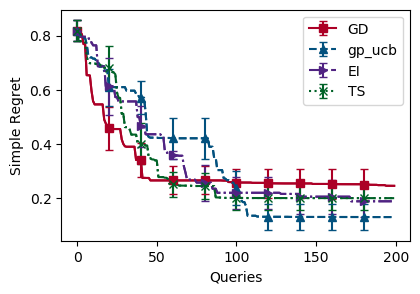

In [9]:
#mean=load_obj(func_name+'_Mean_'+'noisy_'+'Regret')
#error=load_obj(func_name+'_Error_'+'noisy_'+'Regret')
mean=load_obj(func_name+'_Mean_'+'Regret')
error=load_obj(func_name+'_Error_'+'Regret')
save_plot_T(mean,error)
